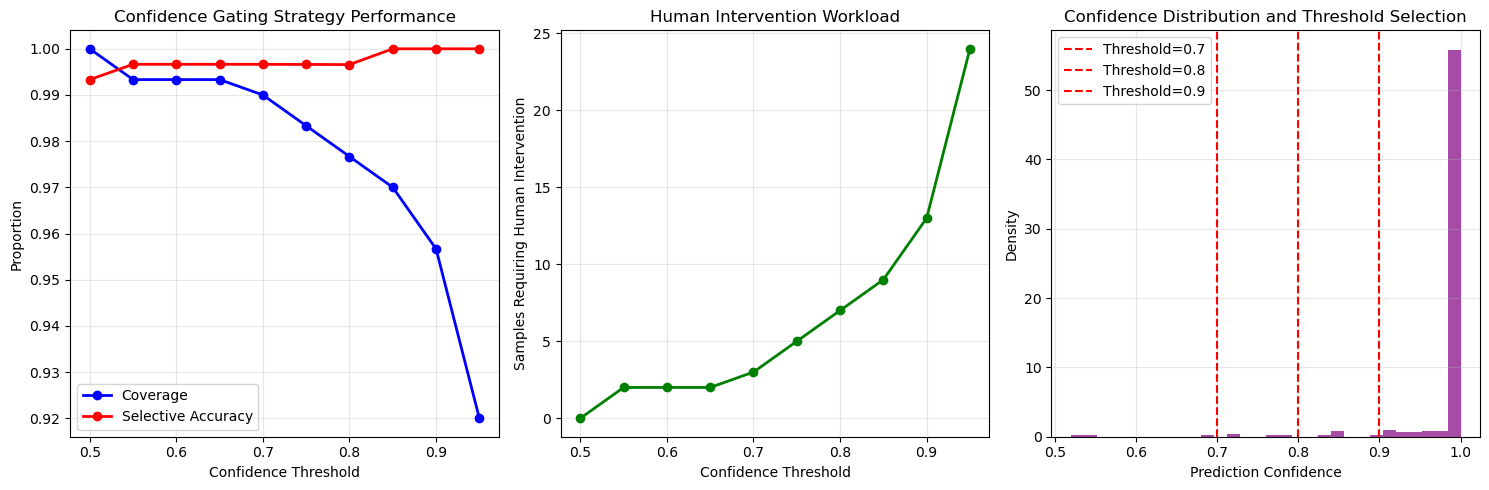


Confidence Gating Strategy Analysis Results
Recommended confidence threshold: 0.50
At this threshold:
  - Automatic decision coverage: 1.000
  - Selective accuracy: 0.993
  - Samples requiring human intervention: 0
  - Human intervention proportion: 0.000

Decision Examples:
Sample 86: True Label=0, Prediction=0, Confidence=1.000, Uncertainty=-0.000, Decision=Automatic Decision
Sample 77: True Label=0, Prediction=0, Confidence=1.000, Uncertainty=-0.000, Decision=Automatic Decision
Sample 69: True Label=0, Prediction=1, Confidence=0.547, Uncertainty=0.689, Decision=Automatic Decision
Sample 46: True Label=0, Prediction=0, Confidence=1.000, Uncertainty=-0.000, Decision=Automatic Decision
Sample 113: True Label=0, Prediction=0, Confidence=1.000, Uncertainty=-0.000, Decision=Automatic Decision


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def confidence_based_control_system():
    """
    Implement confidence-based gating strategy
    
    Input: fastship_dataset.csv file
    Output: Performance evaluation and decision visualization of confidence gating strategy
    Function: Implement intelligent decision system using uncertainty quantification results
    """
    # Load data
    data = pd.read_csv('fastship_dataset.csv')
    X = data.drop('label', axis=1)
    y = data['label']
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Train ensemble model (using medium-sized ensemble)
    n_models = 5
    models = []
    for i in range(n_models):
        model = RandomForestClassifier(
            n_estimators=15,
            max_depth=5,
            random_state=42 + i
        )
        model.fit(X_train, y_train)
        models.append(model)
    
    # Calculate prediction probabilities and uncertainty for test set
    all_probs = []
    for model in models:
        probs = model.predict_proba(X_test)
        all_probs.append(probs)
    
    avg_probs = np.mean(all_probs, axis=0)
    max_probs = np.max(avg_probs, axis=1)  # Maximum class probability as confidence
    uncertainties = -np.sum(avg_probs * np.log(avg_probs + 1e-8), axis=1)  # Entropy as uncertainty
    
    # Define different confidence thresholds
    confidence_thresholds = np.arange(0.5, 0.96, 0.05)
    decision_results = []
    
    for threshold in confidence_thresholds:
        # Apply confidence gating strategy
        high_confidence_mask = max_probs >= threshold
        low_confidence_mask = max_probs < threshold
        
        # High confidence samples: automatic decision
        high_conf_predictions = np.argmax(avg_probs[high_confidence_mask], axis=1)
        high_conf_accuracy = accuracy_score(
            y_test[high_confidence_mask], 
            high_conf_predictions
        ) if np.sum(high_confidence_mask) > 0 else 0
        
        # Low confidence samples: require human intervention
        low_conf_count = np.sum(low_confidence_mask)
        
        # Calculate overall performance metrics
        coverage = np.sum(high_confidence_mask) / len(y_test)  # Automatic decision coverage
        selective_accuracy = high_conf_accuracy
        
        decision_results.append({
            'confidence_threshold': threshold,
            'coverage': coverage,
            'selective_accuracy': selective_accuracy,
            'low_conf_count': low_conf_count,
            'high_conf_accuracy': high_conf_accuracy
        })
    
    # Visualize confidence gating strategy effectiveness
    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Coverage and selective accuracy
    plt.subplot(1, 3, 1)
    thresholds = [r['confidence_threshold'] for r in decision_results]
    coverages = [r['coverage'] for r in decision_results]
    accuracies = [r['selective_accuracy'] for r in decision_results]
    
    plt.plot(thresholds, coverages, 'bo-', linewidth=2, markersize=6, label='Coverage')
    plt.plot(thresholds, accuracies, 'ro-', linewidth=2, markersize=6, label='Selective Accuracy')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Proportion')
    plt.title('Confidence Gating Strategy Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Number of samples requiring human intervention
    plt.subplot(1, 3, 2)
    low_conf_counts = [r['low_conf_count'] for r in decision_results]
    plt.plot(thresholds, low_conf_counts, 'go-', linewidth=2, markersize=6)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Samples Requiring Human Intervention')
    plt.title('Human Intervention Workload')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Confidence distribution and threshold selection
    plt.subplot(1, 3, 3)
    plt.hist(max_probs, bins=30, alpha=0.7, color='purple', density=True)
    for threshold in [0.7, 0.8, 0.9]:
        plt.axvline(x=threshold, color='red', linestyle='--', 
                   label=f'Threshold={threshold}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution and Threshold Selection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('confidence_based_control.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Select optimal threshold and display decision examples
    optimal_idx = np.argmax([r['selective_accuracy'] * r['coverage'] for r in decision_results])
    optimal_result = decision_results[optimal_idx]
    
    print("\n" + "="*60)
    print("Confidence Gating Strategy Analysis Results")
    print("="*60)
    print(f"Recommended confidence threshold: {optimal_result['confidence_threshold']:.2f}")
    print(f"At this threshold:")
    print(f"  - Automatic decision coverage: {optimal_result['coverage']:.3f}")
    print(f"  - Selective accuracy: {optimal_result['selective_accuracy']:.3f}")
    print(f"  - Samples requiring human intervention: {optimal_result['low_conf_count']}")
    print(f"  - Human intervention proportion: {optimal_result['low_conf_count']/len(y_test):.3f}")
    
    # Display some decision examples
    print("\nDecision Examples:")
    example_indices = np.random.choice(len(X_test), 5, replace=False)
    for idx in example_indices:
        true_label = y_test.iloc[idx]
        pred_label = np.argmax(avg_probs[idx])
        confidence = max_probs[idx]
        uncertainty = uncertainties[idx]
        decision = "Automatic Decision" if confidence >= optimal_result['confidence_threshold'] else "Human Intervention"
        
        print(f"Sample {idx}: True Label={true_label}, Prediction={pred_label}, "
              f"Confidence={confidence:.3f}, Uncertainty={uncertainty:.3f}, Decision={decision}")
    
    return decision_results, optimal_result

# Execute confidence-based control strategy analysis
control_results, optimal_setting = confidence_based_control_system()